In [ ]:
# =========================================================
# 0) SETUP: Colab + Dependensi
# =========================================================
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil, os

src = "/content/drive/MyDrive/AI Image Detection/train_data"  # folder tempat file gambar
dst = "/content/train_data"
if not os.path.exists(dst):
    shutil.copytree(src, dst)
print("Copied to", dst)

Copied to /content/train_data


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import regularizers
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=r"Your `PyDataset` class should call `super().__init__\(\*\*kwargs\)`")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AI Image Detection/ai_image_detection.csv")
df.head()

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [ ]:
# drop kolom Unnamed: 0
df = df.drop(columns=['Unnamed: 0'])
df.head()

,file_name,label
0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [ ]:
len(df)

2000

In [ ]:
df['label'].value_counts()

,count
label,
1,1000
0,1000


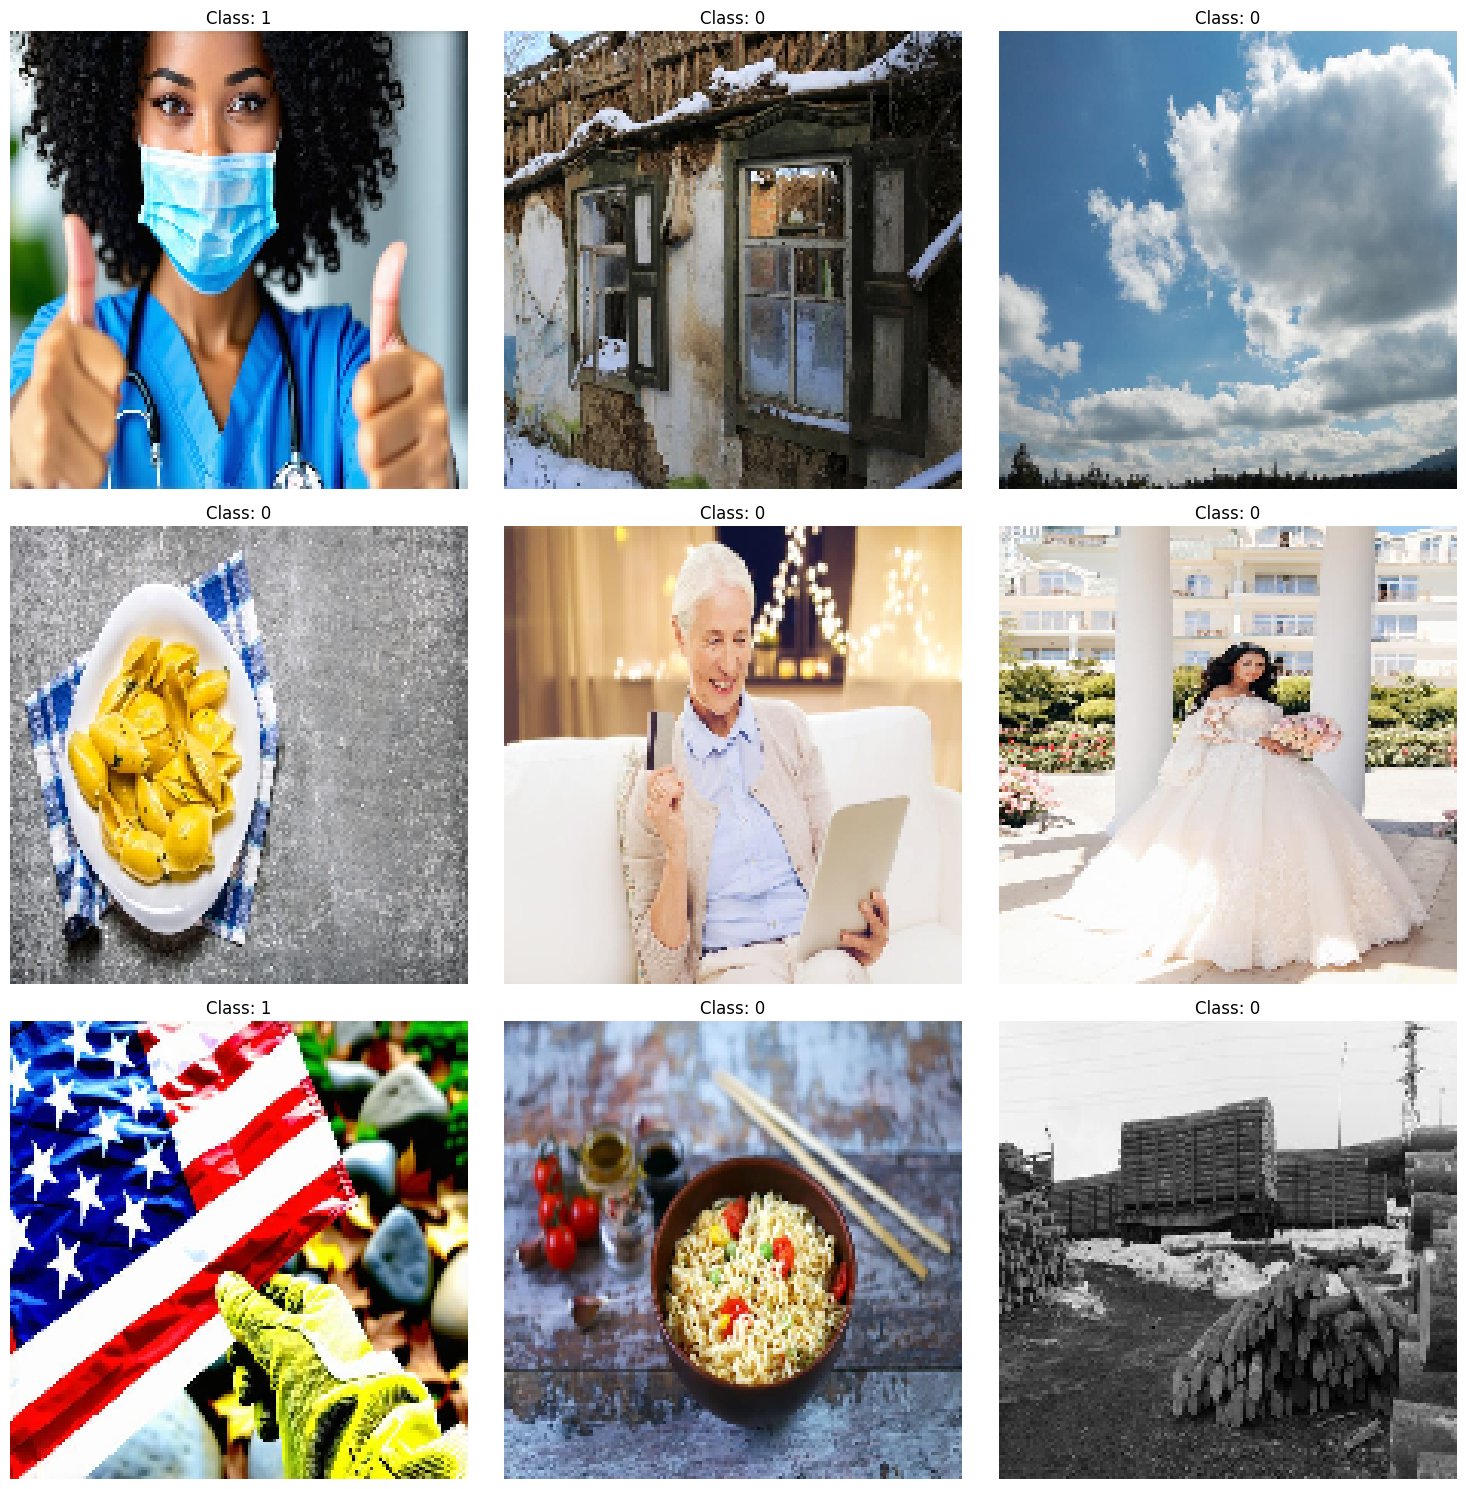

In [ ]:
image_dir = "/content/drive/MyDrive/AI Image Detection/"

sample_images = df.sample(9, random_state=42)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))


for i, (index, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['file_name'])
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize the image

    ax = axes[i // 3, i % 3]
    ax.imshow(img_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert the 'label' column to string type
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

image_dir = "/content/drive/MyDrive/AI Image Detection/"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='file_name',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='file_name',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1600 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [ ]:
model_CNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax') # Changed to 2 units for binary classification
])

model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_CNN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,690 (72.61 MB)

 Trainable params: 19,034,690 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model_CNN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6231 - loss: 1.3082 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 876s 18s/step - accuracy: 0.6246 - loss: 1.2977 - val_accuracy: 0.6589 - val_loss: 0.9351
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7750 - loss: 0.4911 - val_accuracy: 0.8646 - val_loss: 0.3524
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8249 - loss: 0.4107 - val_accuracy: 0.8438 - val_loss: 0.4056
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8710 - loss: 0.3227 - val_accuracy: 0.8646 - val_loss: 0.3110
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8764 - loss: 0.2950 - val_accuracy: 0.8073 - val_loss: 0.5224
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8890 - loss: 0.2706 - val_accuracy: 0.7526 - val_loss: 0.5493
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8939 - loss: 0.2687 - val_accuracy: 0.7891 - val_loss: 0.5431
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8958 - loss: 0.2615 - val_accuracy: 0.7500 - val_loss: 0

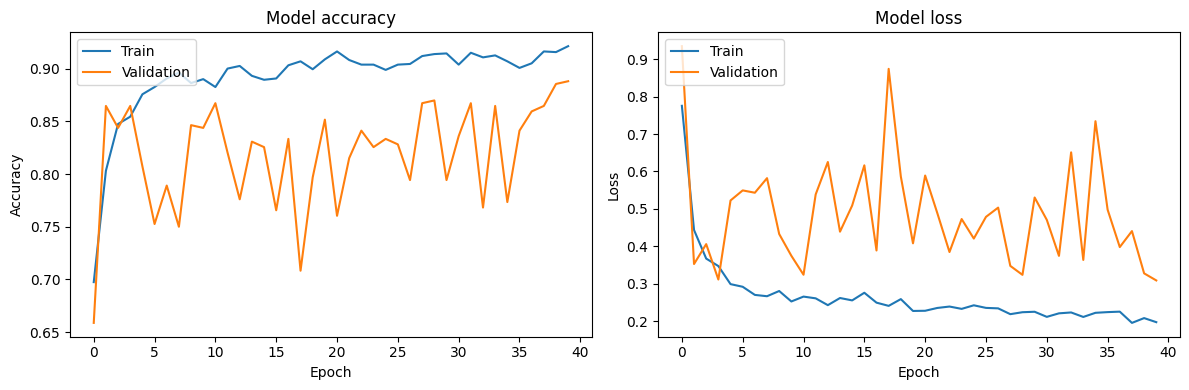

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
val_images, val_labels = next(val_generator)

pred_labels = model_CNN.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

Found 400 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 531ms/step
              precision    recall  f1-score   support

       Human     0.9583    0.8173    0.8822       197
          AI     0.8448    0.9655    0.9011       203

    accuracy                         0.8925       400
   macro avg     0.9016    0.8914    0.8917       400
weighted avg     0.9007    0.8925    0.8918       400



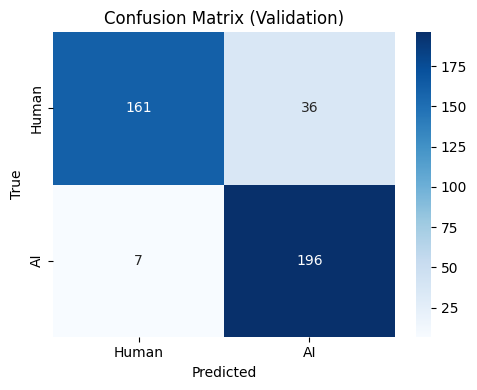

Human accuracy: 0.8173
AI accuracy: 0.9655


In [ ]:
# === 1) Buat generator validasi TANPA shuffle (biar urutannya stabil) ===
val_predict_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df.astype({'label': 'str'}).copy(),
    directory=image_dir,
    x_col='file_name',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # penting!
)

# === 2) Prediksi seluruh validation set ===
pred_probs = model_CNN.predict(val_predict_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_predict_gen.classes  # urutannya cocok dengan prediksi karena shuffle=False

# === 3) Siapkan nama kelas (sesuai urutan index) ===
ci = val_predict_gen.class_indices                 # contoh: {'0': 0, '1': 1}
idx_to_class = {v: k for k, v in ci.items()}       # {0: '0', 1: '1'}
target_names = [idx_to_class[i] for i in range(len(ci))]

# (Opsional) kalau mau label lebih ramah:
pretty = {'0': 'Human', '1': 'AI'}
pretty_names = [pretty.get(n, n) for n in target_names]

# === 4) Classification report ===
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=pretty_names, digits=4))

# === 5) Confusion matrix (plot) ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=pretty_names, yticklabels=pretty_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Validation)')
plt.tight_layout()
plt.show()

# (Opsional) Per-class accuracy ringkas
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for name, acc in zip(pretty_names, per_class_acc):
    print(f"{name} accuracy: {acc:.4f}")

In [ ]:
# Save Models
model_CNN.save('/content/model_CNN.h5')